In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '/home/jw3514/Work/ASD_Circuits/src')
from ASD_Circuits import *
from tabulate import tabulate

/home/jw3514/anaconda3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
InfoMat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.csv", index_col=0)
adj_mat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/WeightMat.Ipsi.csv", index_col=0)

InfoMat_short = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.short.csv", index_col=0)

InfoMat_long = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/InfoMat.Ipsi.long.csv", index_col=0)

In [30]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)

def searchFil(text, DIR):
    #print(text)
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES

def LoadSA3(fname, DIR, adj_mat, topL=100):
    fin = open(DIR+fname, 'rt')
    max_score, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        score = ScoreCircuit_NEdges(STRs, adj_mat)
        if score > max_score:
            max_score = score
            max_bias = bias
            max_STRs = STRs
    return max_score, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat):
    SCORES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        score, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat)
        score = ScoreCircuit_NEdges(STRs, adj_mat)
        if score == 0:
            continue
        SCORES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return SCORES, CutBias, RealBias, STRS

def XXXX_cont(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat):
    #fil = searchFil("keepN_{}-minbias_{}.txt".format(size, bias), DIR)[0]
    SCORES, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat)
    New_RealBias = []
    for STRSET in STRS:
        xx = BiasDF.loc[STRSET, "EFFECT"].mean()
        New_RealBias.append(xx)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_NEdges(topNSTRs, adj_mat)
    SCORES.append(score)
    CutBias.append(bias)
    New_RealBias.append(bias)
    STRS.append(topNSTRs)    
    return SCORES, CutBias, New_RealBias, STRS

def search_target_swap(size, BiasDF, NSwap, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        NDiff = len(set(STRs).difference(topNSTRs))
        if abs(NDiff-NSwap) < 2:

            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score > 0.714:
                #print(RegionDistributionsList(STRs))
                print(score, score1, score2)
            return bias, score, score1, score2
    return None, None, None, None

def search_target_swap2(size, BiasDF, biaslim, biaslim_df, adj_mat, 
                       ProbMat1, ProbMat1_short, ProbMat1_long, 
                       ProbMat2, ProbMat2_short, ProbMat2_long, DIR):
    # TopN targets 
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF.head(size)["EFFECT"].mean()
    score = ScoreCircuit_v7(topNSTRs, adj_mat, ProbMat1, ProbMat2)
    # search along the profile
    for i, row in biaslim_df.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        cohe, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat, ProbMat1, ProbMat2)
        score = ScoreCircuit_v7(STRs, adj_mat, ProbMat1, ProbMat2)

        bias = BiasDF.loc[STRs, "EFFECT"].mean()
        #print(round(real_minbias,3), biaslim)
        if round(real_minbias,3) == biaslim:
            score1 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_short, ProbMat2_short)
            score2 = ScoreCircuit_v7(STRs, adj_mat, ProbMat1_long, ProbMat2_long)
            if score2 > 0.673:
                #print()
                print(RegionDistributionsList(STRs))
            return bias, score, score1, score2
    return None, None, None, None

def LoadProfiles(BiasDF, BiasDF2, biaslim_df, size, DIR, adj_mat):
    Scores, CutBias, RealBias, STRS = GetData2(biaslim_df, size, DIR, adj_mat)
    # Add top size STRs
    topNSTRs = BiasDF.index.values[:size]
    bias = BiasDF2.head(size)["EFFECT"].mean()
    score = ScoreCircuit_NEdges(topNSTRs, adj_mat)
    Scores.append(score)
    CutBias.append(bias)
    RealBias.append(bias)
    STRS.append(topNSTRs)    
    return Scores, CutBias, RealBias, STRS

In [11]:
size = 46
#biaslim_df = pd.read_csv(biaslim_dir + "biaslim.size.{}.txt".format(size), names=["size", "bias"])
ASD_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/ASD_Pareto_Conn_Size46/"
ASD_BiasDF = pd.read_csv("../dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", index_col="STR")
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])
COHESPeak, CutBiasPeak, RealBiasPeak, STRSPeak = LoadProfiles(ASD_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                              ASD_DIR, adj_mat)
ASD_DFPeak = pd.DataFrame(data={"Cohe":COHESPeak, "minBias":CutBiasPeak, "Bias":RealBiasPeak})

In [75]:
print(RegionDistributionsList(STRSPeak[-4]))

Striatum	3	Nucleus_accumbens; Caudoputamen; Lateral_septal_nucleus_rostral_rostroventral_part
Isocortex	19	Orbital_area_lateral_part; Prelimbic_area; Primary_somatosensory_area_lower_limb; Orbital_area_ventrolateral_part; Infralimbic_area; Anteromedial_visual_area; Retrosplenial_area_lateral_agranular_part; Primary_visual_area; Primary_motor_area; Secondary_motor_area; Anterior_cingulate_area_dorsal_part; Posterior_parietal_association_areas; Lateral_visual_area; Agranular_insular_area_posterior_part; Primary_somatosensory_area_trunk; Gustatory_areas; Agranular_insular_area_ventral_part; Supplemental_somatosensory_area; Orbital_area_medial_part
Olfactory_areas	3	Anterior_olfactory_nucleus; Dorsal_peduncular_area; Piriform_area
Amygdala	3	Lateral_amygdalar_nucleus; Basomedial_amygdalar_nucleus; Basolateral_amygdalar_nucleus
Thalamus	8	Parafascicular_nucleus; Nucleus_of_reuniens; Lateral_posterior_nucleus_of_the_thalamus; Rhomboid_nucleus; Submedial_nucleus_of_the_thalamus; Parataenial_n

In [34]:
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])

SIB_SA_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Circuits/SA/SubSib_Score_Conn_Nov_2023/"
SIB_BIAS_DIR = "/home/jw3514/Work/ASD_Circuits/dat/Unionize_bias/SubSampleSib/"

dat_score = []
dat_bias = []

for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    #try:
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        biasdf = SIB_BIAS_DIR + file + ".csv"
        Sib_BiasDF = pd.read_csv(biasdf, index_col="STR")

            
        try:
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            COHES55, CutBias55, RealBias55, STRS55 = XXXX_cont(Sib_BiasDF, ASD_BiasDF, biaslim_df, size, 
                                                          ASD_cont_Dir, adj_mat)
            dat_score.append(COHES55)
            dat_bias.append(RealBias55)
        except:
            continue


keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.

keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.

keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.

keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.

keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.

keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.t

keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.txt
keepN_46-minbias_0.335.txt
keepN_46-minbias_0.34.txt
keepN_46-minbias_0.345.txt
keepN_46-minbias_0.35.txt
keepN_46-minbias_0.355.txt
keepN_46-minbias_0.36.txt
keepN_46-minbias_0.365.txt
keepN_46-minbias_0.37.txt
keepN_46-minbias_0.375.txt
keepN_46-minbias_0.38.txt
keepN_46-minbias_0.3.txt
keepN_46-minbias_0.305.txt
keepN_46-minbias_0.31.txt
keepN_46-minbias_0.315.txt
keepN_46-minbias_0.32.txt
keepN_46-minbias_0.325.txt
keepN_46-minbias_0.33.

In [35]:
dat_score = np.array(dat_score)
dat_score_flat = dat_score.flatten()
dat_bias = np.array(dat_bias)
dat_bias_flat = dat_bias.flatten()

In [36]:
dat_score

array([[0.19943289, 0.19565217, 0.19281664, ..., 0.10586011, 0.08931947,
        0.06758034],
       [0.16871456, 0.16729679, 0.1668242 , ..., 0.10018904, 0.0879017 ,
        0.07183365],
       [0.18572779, 0.18289225, 0.17816635, ..., 0.08931947, 0.07655955,
        0.05765595],
       ...,
       [0.20085066, 0.19990548, 0.19801512, ..., 0.09357278, 0.07372401,
        0.05198488],
       [0.19754253, 0.19470699, 0.19234405, ..., 0.1063327 , 0.08648393,
        0.07088847],
       [0.19848771, 0.19754253, 0.19612476, ..., 0.1294896 , 0.11058601,
        0.09215501]])

In [37]:
Sib_DF55 = pd.DataFrame(data={"SI score":dat_score_flat, "Bias":dat_bias_flat})
Sib_DF55.shape

(8640, 2)

In [38]:
profiles = []
for bias, score in zip(dat_bias, dat_score):
    meanbias = np.mean(bias)
    meanscore = np.mean(score)
    meantotal = meanbias + meanscore
    profiles.append([meanbias, meanscore, meantotal, bias, score])

In [39]:
rank_bias = sorted(profiles, key = lambda x:x[0], reverse=True)
rank_score = sorted(profiles, key = lambda x:x[1], reverse=True)

In [40]:
topbias = []
for i in range(len(profiles)):
    topbias.append((rank_bias[i][4], rank_bias[i][3]))
topbias = np.array(topbias)
topSI = []
for i in range(len(profiles)):
    topSI.append((rank_score[i][4], rank_score[i][3]))
topSI = np.array(topSI)

In [41]:
topbias.shape

(480, 2, 18)

In [72]:
# subsample subsample sibs
rand_indexes = np.random.randint(0, topbias.shape[0], 480)
topbias_sub = topbias[rand_indexes]

In [73]:
meanbias = []
meanSI = []
xerr = []
yerr = []
for i in range(topbias.shape[2]):
    meanbias.append(topbias[:,1,i].mean())
    meanSI.append(topbias[:,0,i].mean())
    xerr.append(topbias[:,0,i].std())
    yerr.append(topbias[:,1,i].std())

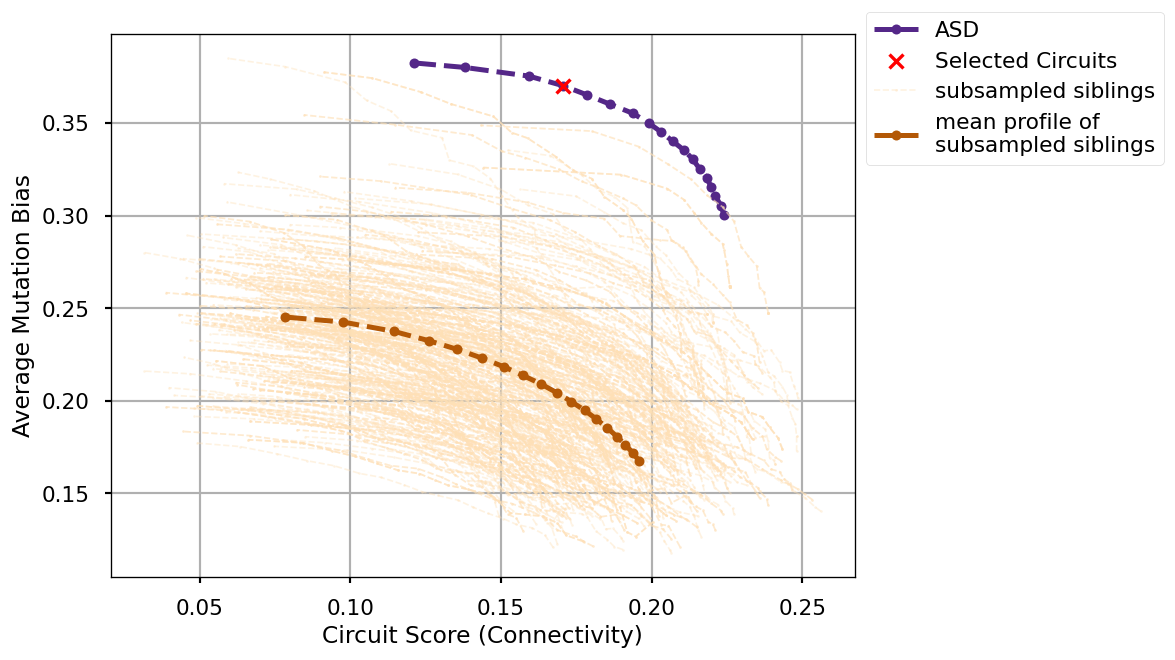

In [76]:
fig, ax = plt.subplots(dpi=120, figsize=(10,6))

ax.plot(ASD_DFPeak["Cohe"].values, ASD_DFPeak["Bias"].values, marker=".", color="#542788",  lw=3, markersize=12,
             ls = "--", label="ASD")
ax.scatter(ASD_DFPeak["Cohe"].values[-4], ASD_DFPeak["Bias"].values[-4], marker="x", s=70, color="red", lw=2,
           zorder=100, label="Selected Circuits")

N=5200
#plt.plot(topbias[:N,0,:].T, topbias[:N,1,:].T, marker=".", color="grey",
#             ls = "--", alpha=0.1, label="subsampled siblings")
ax.plot(topbias_sub[:,0,:].T, topbias_sub[:,1,:].T, marker=".", color="#fee0b6", markersize=3, lw=1,
             ls = "--", alpha=0.4)
ax.plot(topbias_sub[0,0,:].T, topbias_sub[0,1,:].T, marker=".", color="#fee0b6", markersize=3, lw=1,
             ls = "--", alpha=0.4, label="subsampled siblings")

ax.plot(meanSI, meanbias, marker=".", color="#b35806", lw=3, markersize=12,
             ls = "--", alpha=1, label="mean profile of \nsubsampled siblings")


#handles, labels = plt.gca().get_legend_handles_labels()
#labels, ids = np.unique(labels, return_index=True)
#handles = [handles[i] for i in ids]
#plt.legend(handles, labels, loc='best')
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc="center left", bbox_to_anchor=(1, 0.9))

plt.xlabel("Circuit Score (Connectivity)", fontsize=14)
plt.ylabel("Average Mutation Bias", fontsize=14)
plt.grid(True)

plt.show()

### Distance graph with conn

##### Load diatance related function and data

In [50]:
def MaskDistMat(Mat1, Mat2, cutoff, m='lt'):
    New_Mat2 = Mat2.copy(deep=True)
    for STR_i in Mat1.index.values:
        for STR_j in Mat1.columns.values:
            if m == 'gt':
                if Mat1.loc[STR_i, STR_j] >= cutoff:
                    New_Mat2.loc[STR_i, STR_j] = 0
                else:
                    New_Mat2.loc[STR_i, STR_j] = Mat2.loc[STR_i, STR_j]
            elif m == "lt":
                if Mat1.loc[STR_i, STR_j] <= cutoff:
                    New_Mat2.loc[STR_i, STR_j] = 0
                else:
                    New_Mat2.loc[STR_i, STR_j] = Mat2.loc[STR_i, STR_j]
    return New_Mat2

def MaskDistMat_xx(distance_mat, Conn_mat, cutoff, cutoff2, keep='gt'):
    Conn_mat_new = Conn_mat.copy(deep=True)
    distance_mat_new = distance_mat.copy(deep=True)
    for STR_i in distance_mat.index.values:
        for STR_j in distance_mat.columns.values:
            if keep == 'gt':
                if distance_mat.loc[STR_i, STR_j] >= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0
            elif keep == "lt":
                if distance_mat.loc[STR_i, STR_j] <= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0   
            elif keep=="bw":
                if distance_mat.loc[STR_i, STR_j] >= cutoff and distance_mat.loc[STR_i, STR_j] <= cutoff2:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0   
    return Conn_mat_new, distance_mat_new

def MaskDistMat_xy(distance_mat, Conn_mat, cutoff, cutoff2, keep='gt'):
    Conn_mat_new = Conn_mat.copy(deep=True)
    distance_mat_new = distance_mat.copy(deep=True)
    for STR_i in distance_mat.index.values:
        for STR_j in distance_mat.columns.values:
            if STR_i == STR_j:
                Conn_mat_new.loc[STR_i, STR_j] = 0
                distance_mat_new.loc[STR_i, STR_j] = 0
                continue
            if keep == 'gt':
                if distance_mat.loc[STR_i, STR_j] >= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0
            elif keep == "lt":
                if distance_mat.loc[STR_i, STR_j] <= cutoff:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0
            elif keep=="bw":
                if distance_mat.loc[STR_i, STR_j] >= cutoff and distance_mat.loc[STR_i, STR_j] <= cutoff2:
                    Conn_mat_new.loc[STR_i, STR_j] = Conn_mat.loc[STR_i, STR_j]
                    distance_mat_new.loc[STR_i, STR_j] = distance_mat.loc[STR_i, STR_j]
                else:
                    Conn_mat_new.loc[STR_i, STR_j] = 0
                    distance_mat_new.loc[STR_i, STR_j] = 0
    return Conn_mat_new, distance_mat_new

In [51]:
adj_mat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/WeightMat.Ipsi.csv", index_col=0)
dist_mat = pd.read_csv("../dat/allen-mouse-conn/Dist_CartesianDistance.ipsi.csv", index_col=0)
dist_mat.columns = dist_mat.index.values

In [52]:
Cartesian_distances_w_edge = MaskDistMat(adj_mat, dist_mat, cutoff=0)
#Distance_Cuts = [0, 1000, 2000, 3000, 4000, 5000, 100000]
Distance_Cuts = [0, 1000, 2000, 3000, 4000, 100000]

N_Connections_total = []
N_Pairs_total = []
Cutted_DistMat = {}
Cutted_AdjMat = {}
for i, cut in enumerate(Distance_Cuts[:-1]):
    Conn_mat_new, distance_mat_new = MaskDistMat_xy(dist_mat, adj_mat, keep="bw",
                                                cutoff=Distance_Cuts[i], cutoff2=Distance_Cuts[i+1])
    Cutted_DistMat[i] = distance_mat_new
    Cutted_AdjMat[i] = Conn_mat_new
    N_Connections_total.append(np.count_nonzero(Conn_mat_new))
    N_Pairs_total.append(np.count_nonzero(distance_mat_new))
N_Connections_total = np.array(N_Connections_total)
N_Pairs_total = np.array(N_Pairs_total)

##### Load ASD and sib data

In [57]:
def normtoUnit(x, xmin, xmax):
    return (x-xmin)/(xmax-xmin)

def searchFil(text, DIR):
    RES = []
    for file in os.listdir(DIR):
        if text in file:
            RES.append(file)
    return RES

def LoadSA3(fname, DIR, adj_mat, topL=100):
    fin = open(DIR+fname, 'rt')
    max_score, max_bias, max_STRs = 0, 0, []
    for i, l in enumerate(fin):
        if i > topL:
            break
        l = l.strip().split()
        bias = float(l[1])
        STRs = l[2].split(",")
        score = ScoreCircuit_NEdges(STRs, adj_mat)
        if score > max_score:
            max_score = score
            max_bias = bias
            max_STRs = STRs
    return max_score, max_bias, max_STRs

def GetData2(params, size, DIR, adj_mat):
    SCORES, CutBias, RealBias, STRS = [],[],[],[]
    for i, row in params.iterrows():
        fil = searchFil("keepN_{}-minbias_{}.txt".format(size, row["bias"]), DIR)[0]
        score, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat)
        score = ScoreCircuit_NEdges(topNSTRs, adj_mat)
        if score == 0:
            continue
        SCORES.append(score)
        CutBias.append(row["bias"])
        RealBias.append(real_minbias)
        STRS.append(STRs)
    return SCORES, CutBias, RealBias, STRS

def ExtractSibSTR(bias_cut, DIR, adj_mat):
    fil = searchFil("topN_121-keepN_46-minbias_{}.txt".format(bias_cut), DIR)[0]
    score, real_minbias, STRs = LoadSA3(fil, DIR, adj_mat) 
    return STRs

In [47]:
biaslim_df = pd.read_csv(
    "../dat/Circuits/SA/biaslims2/biaslim.size.46.top17.txt", names=["size", "bias"])
adj_mat = pd.read_csv("../dat/allen-mouse-conn/ScoreingMat_jw_v3/WeightMat.Ipsi.csv", index_col=0)

In [53]:
ASD_STR_Bias = pd.read_csv("../../ASD_Circuits/dat/Unionize_bias/Spark_Meta_EWS.Z2.bias.csv", 
                           index_col="STR")
ASD_Circuits = STRSPeak[-4]
ASD_Connections = []
ASD_Pairs = []
for i,v in enumerate(Distance_Cuts[:-1]):
    adj_mat_ = Cutted_AdjMat[i]
    dist_mat_ = Cutted_DistMat[i]
    adj_mat_asd = adj_mat_.loc[ASD_Circuits,ASD_Circuits]
    dist_mat_asd = dist_mat_.loc[ASD_Circuits,ASD_Circuits]
    Nconn = np.count_nonzero(adj_mat_asd)
    Npair = np.count_nonzero(dist_mat_asd)
    ASD_Connections.append(Nconn)
    ASD_Pairs.append(Npair)
ASD_Connections = np.array(ASD_Connections)
ASD_Pairs = np.array(ASD_Pairs)
print(ASD_STR_Bias.loc[ASD_Circuits, "EFFECT"].mean())

0.37014518868811974


In [59]:
bias_cut = 0.37
Sib_Cir_STRs = []
for i, file in enumerate(os.listdir(SIB_SA_DIR)):
    d = os.path.join(SIB_SA_DIR, file)
    if os.path.isdir(d):
        try:
            ASD_cont_Dir = SIB_SA_DIR + file + "/"
            Sib_CirSTR = ExtractSibSTR(bias_cut, ASD_cont_Dir, adj_mat)
            Sib_Cir_STRs.append(Sib_CirSTR)
        except:
            continue
    #if i > 10:

In [60]:
len(Sib_Cir_STRs)

500

In [61]:
subsib_connections = []
subsib_Pairs = []
Sim_dir = "../dat/Unionize_bias/SubSampleSib//"
for i, _SibSTRs in enumerate(Sib_Cir_STRs):
    _SIB_Connections = []
    _SIB_Pairs = []
    for i,v in enumerate(Distance_Cuts[:-1]):
        adj_mat_ = Cutted_AdjMat[i]
        dist_mat_ = Cutted_DistMat[i]
        adj_mat_sib = adj_mat_.loc[_SibSTRs,_SibSTRs]
        dist_mat_sib = dist_mat_.loc[_SibSTRs,_SibSTRs]
        Nconn = np.count_nonzero(adj_mat_sib)
        Npair = np.count_nonzero(dist_mat_sib)
        _SIB_Connections.append(Nconn)
        _SIB_Pairs.append(Npair)
    subsib_connections.append(_SIB_Connections)
    subsib_Pairs.append(_SIB_Pairs)
subsib_connections = np.array(subsib_connections)
subsib_Pairs = np.array(subsib_Pairs)

In [62]:
subsib_connections.shape

(500, 5)

In [63]:
subsib_conns_mean =  np.mean(subsib_connections, axis=0)
subsib_conns_std =  np.std(subsib_connections, axis=0)
subsib_pairs_mean =  np.mean(subsib_Pairs, axis=0)
subsib_pairs_std =  np.std(subsib_Pairs, axis=0)

In [64]:
for asd, sibs in zip(ASD_Connections, subsib_connections.T):
    #print(asd, len(sibs))
    z,p = GetPermutationP(sibs, asd)
    print(p)

0.5209580838323353
0.7844311377245509
0.33333333333333337
0.027944111776447067
0.003992015968063867


In [65]:
# significance of connection enrichment:
for asd, sibs in zip(ASD_Connections, subsib_connections.T):
    #print(asd, len(sibs))
    #z,p = GetPermutationP(sibs, asd)
    #print(p)
    print(np.mean(sibs))

20.182
86.986
71.758
44.246
30.412


In [66]:
# significance of connection pairs:
for asd, sibs in zip(ASD_Pairs, subsib_Pairs.T):
    #print(asd, len(sibs))
    z,p = GetPermutationP(sibs, asd)
    print(p)

0.8542914171656687
0.9540918163672655
0.8323353293413174
0.031936127744510934
0.24750499001996007


In [67]:
# significance of fc:
norm = N_Connections_total/N_Pairs_total
for asd, sibs in zip(ASD_Connections/ASD_Pairs / norm, (subsib_connections/subsib_Pairs / norm).T):
    #print(asd, len(sibs))
    z,p = GetPermutationP(sibs, asd)
    print(p)

0.28742514970059885
0.24151696606786432
0.12375249500998009
0.08383233532934131
0.02594810379241519


In [68]:
split_idx = 3
CaseGroup1 = np.sum(ASD_Connections[:split_idx])/np.sum(N_Connections_total[:split_idx])
CaseGroup2 = np.sum(ASD_Connections[split_idx:])/np.sum(N_Connections_total[split_idx:])
CtrlGroup1 = np.sum(subsib_connections[:, :split_idx], axis=1)/np.sum(N_Connections_total[:split_idx])
CtrlGroup2 = np.sum(subsib_connections[:, split_idx:], axis=1)/np.sum(N_Connections_total[split_idx:])

# significance of fc:
z,p = GetPermutationP(CtrlGroup1, CaseGroup1)
print(p)

z,p = GetPermutationP(CtrlGroup2, CaseGroup2)
print(p)

0.6107784431137724
0.009980039920159722


In [69]:
split_idx = 3
CaseGroup1 = np.sum(ASD_Connections[:split_idx])/np.sum(ASD_Pairs[:split_idx])/np.sum(N_Connections_total[:split_idx]/N_Pairs_total[:split_idx])
CaseGroup2 = np.sum(ASD_Connections[split_idx:])/np.sum(ASD_Pairs[split_idx:])/np.sum(N_Connections_total[split_idx:]/N_Pairs_total[split_idx:])
CtrlGroup1 = np.sum(subsib_connections[:, :split_idx], axis=1)/np.sum(subsib_Pairs[:, :split_idx], axis=1)/np.sum(N_Connections_total[:split_idx]/N_Pairs_total[:split_idx])
CtrlGroup2 = np.sum(subsib_connections[:, split_idx:], axis=1)/np.sum(subsib_Pairs[:, split_idx:], axis=1)/np.sum(N_Connections_total[split_idx:]/N_Pairs_total[split_idx:])

# significance of fc:
z,p = GetPermutationP(CtrlGroup1, CaseGroup1)
print(p)

z,p = GetPermutationP(CtrlGroup2, CaseGroup2)
print(p)

0.1936127744510978
0.027944111776447067


/tmp/ipykernel_2773314/2925915916.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')
/tmp/ipykernel_2773314/2925915916.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", r">4"], fontsize=20)


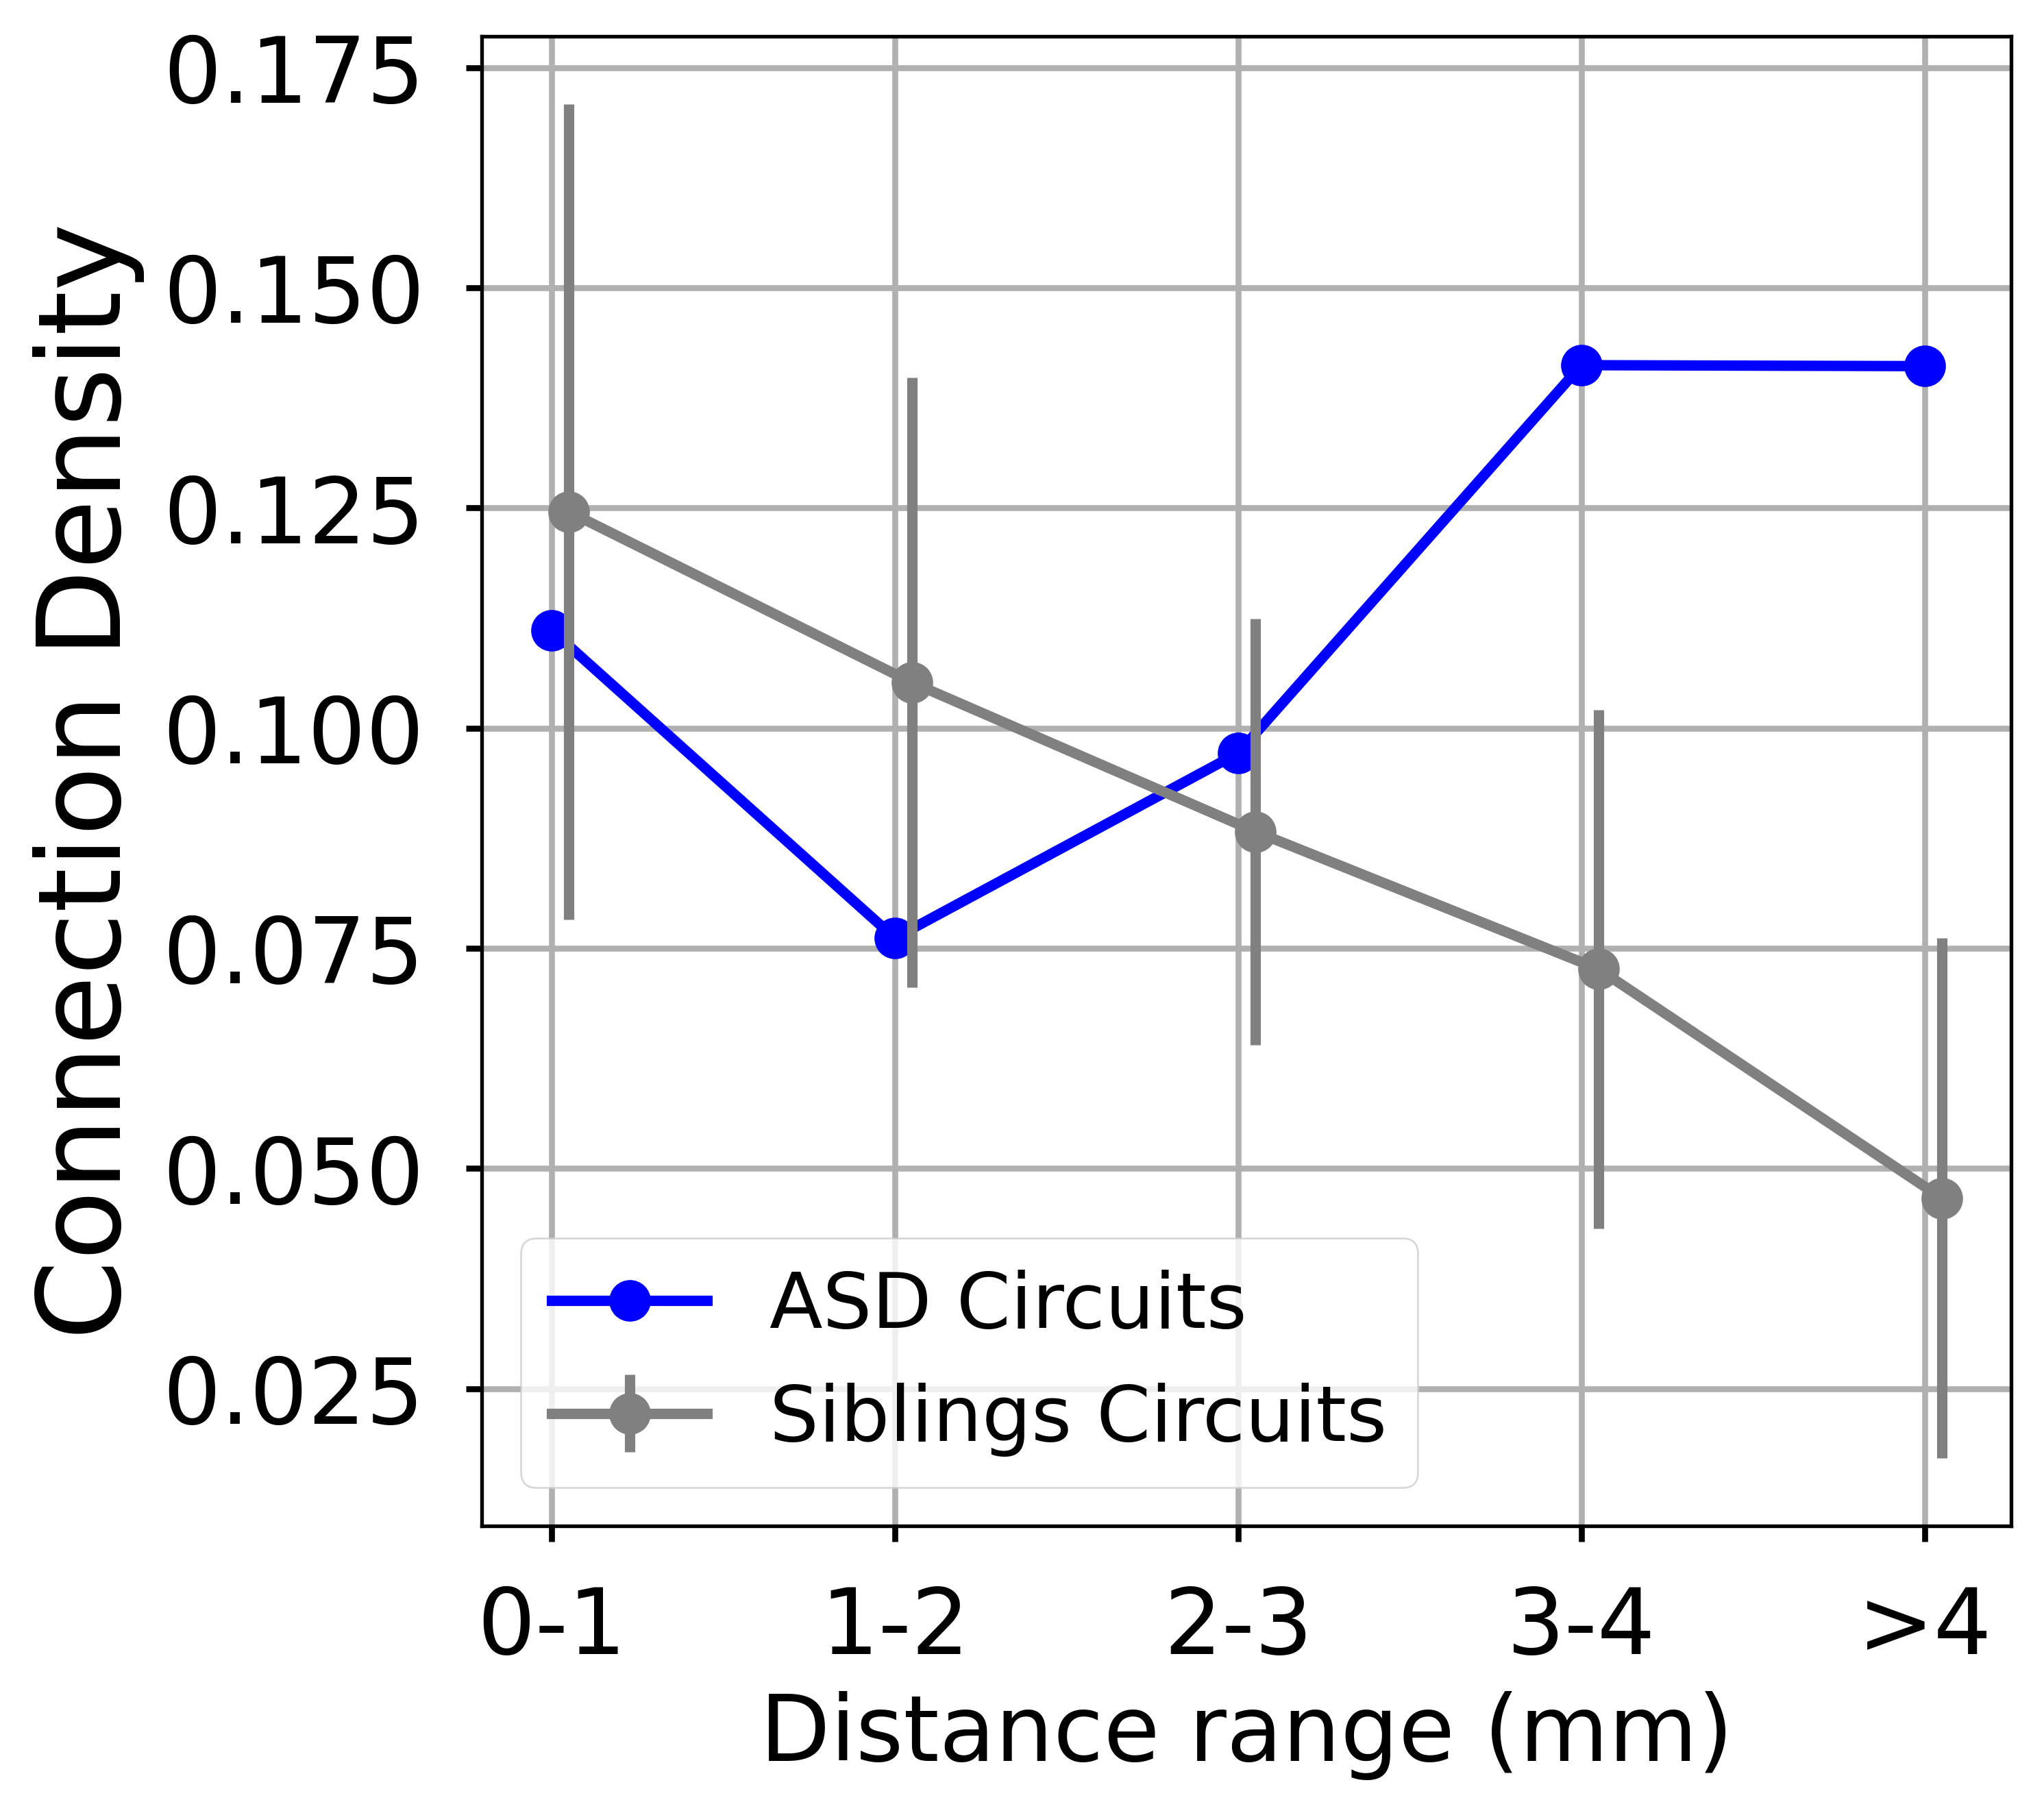

In [70]:
%matplotlib inline
import matplotlib.ticker as mticker  
plt.style.use('seaborn-talk')
matplotlib.rcParams.update({'font.size': 25})
fig, ax = plt.subplots(dpi=480, figsize=(6,6))

ax.plot(np.arange(5), ASD_Connections/N_Connections_total, marker="o" , color="blue", label="ASD Circuits")
#ax.plot(np.arange(6) + 0.05, SIB_Connections/N_Connections_total, marker="o", color="orange", label="Sibling Circuits")
ax.errorbar(np.arange(5) + 0.05, 
                 subsib_conns_mean/N_Connections_total, 
                 yerr= np.nanstd(subsib_connections/N_Connections_total, axis=0), #subsib_conns_std/N_Connections_total,
                 marker="o", color="grey", label="Siblings Circuits",)

ax.grid(True)
ax.legend(loc="lower left", fontsize=17)
ax.set_ylabel("Connection Density", fontsize=25)
ax.set_xlabel(r"Distance range (mm)", fontsize=20)
#ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", "4-5", r">5"], fontsize=20)
ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", r">4"], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
#ax.set_ylim(0, 0.17)
plt.show()

/tmp/ipykernel_2773314/1741187616.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", r">4"], fontsize=20)


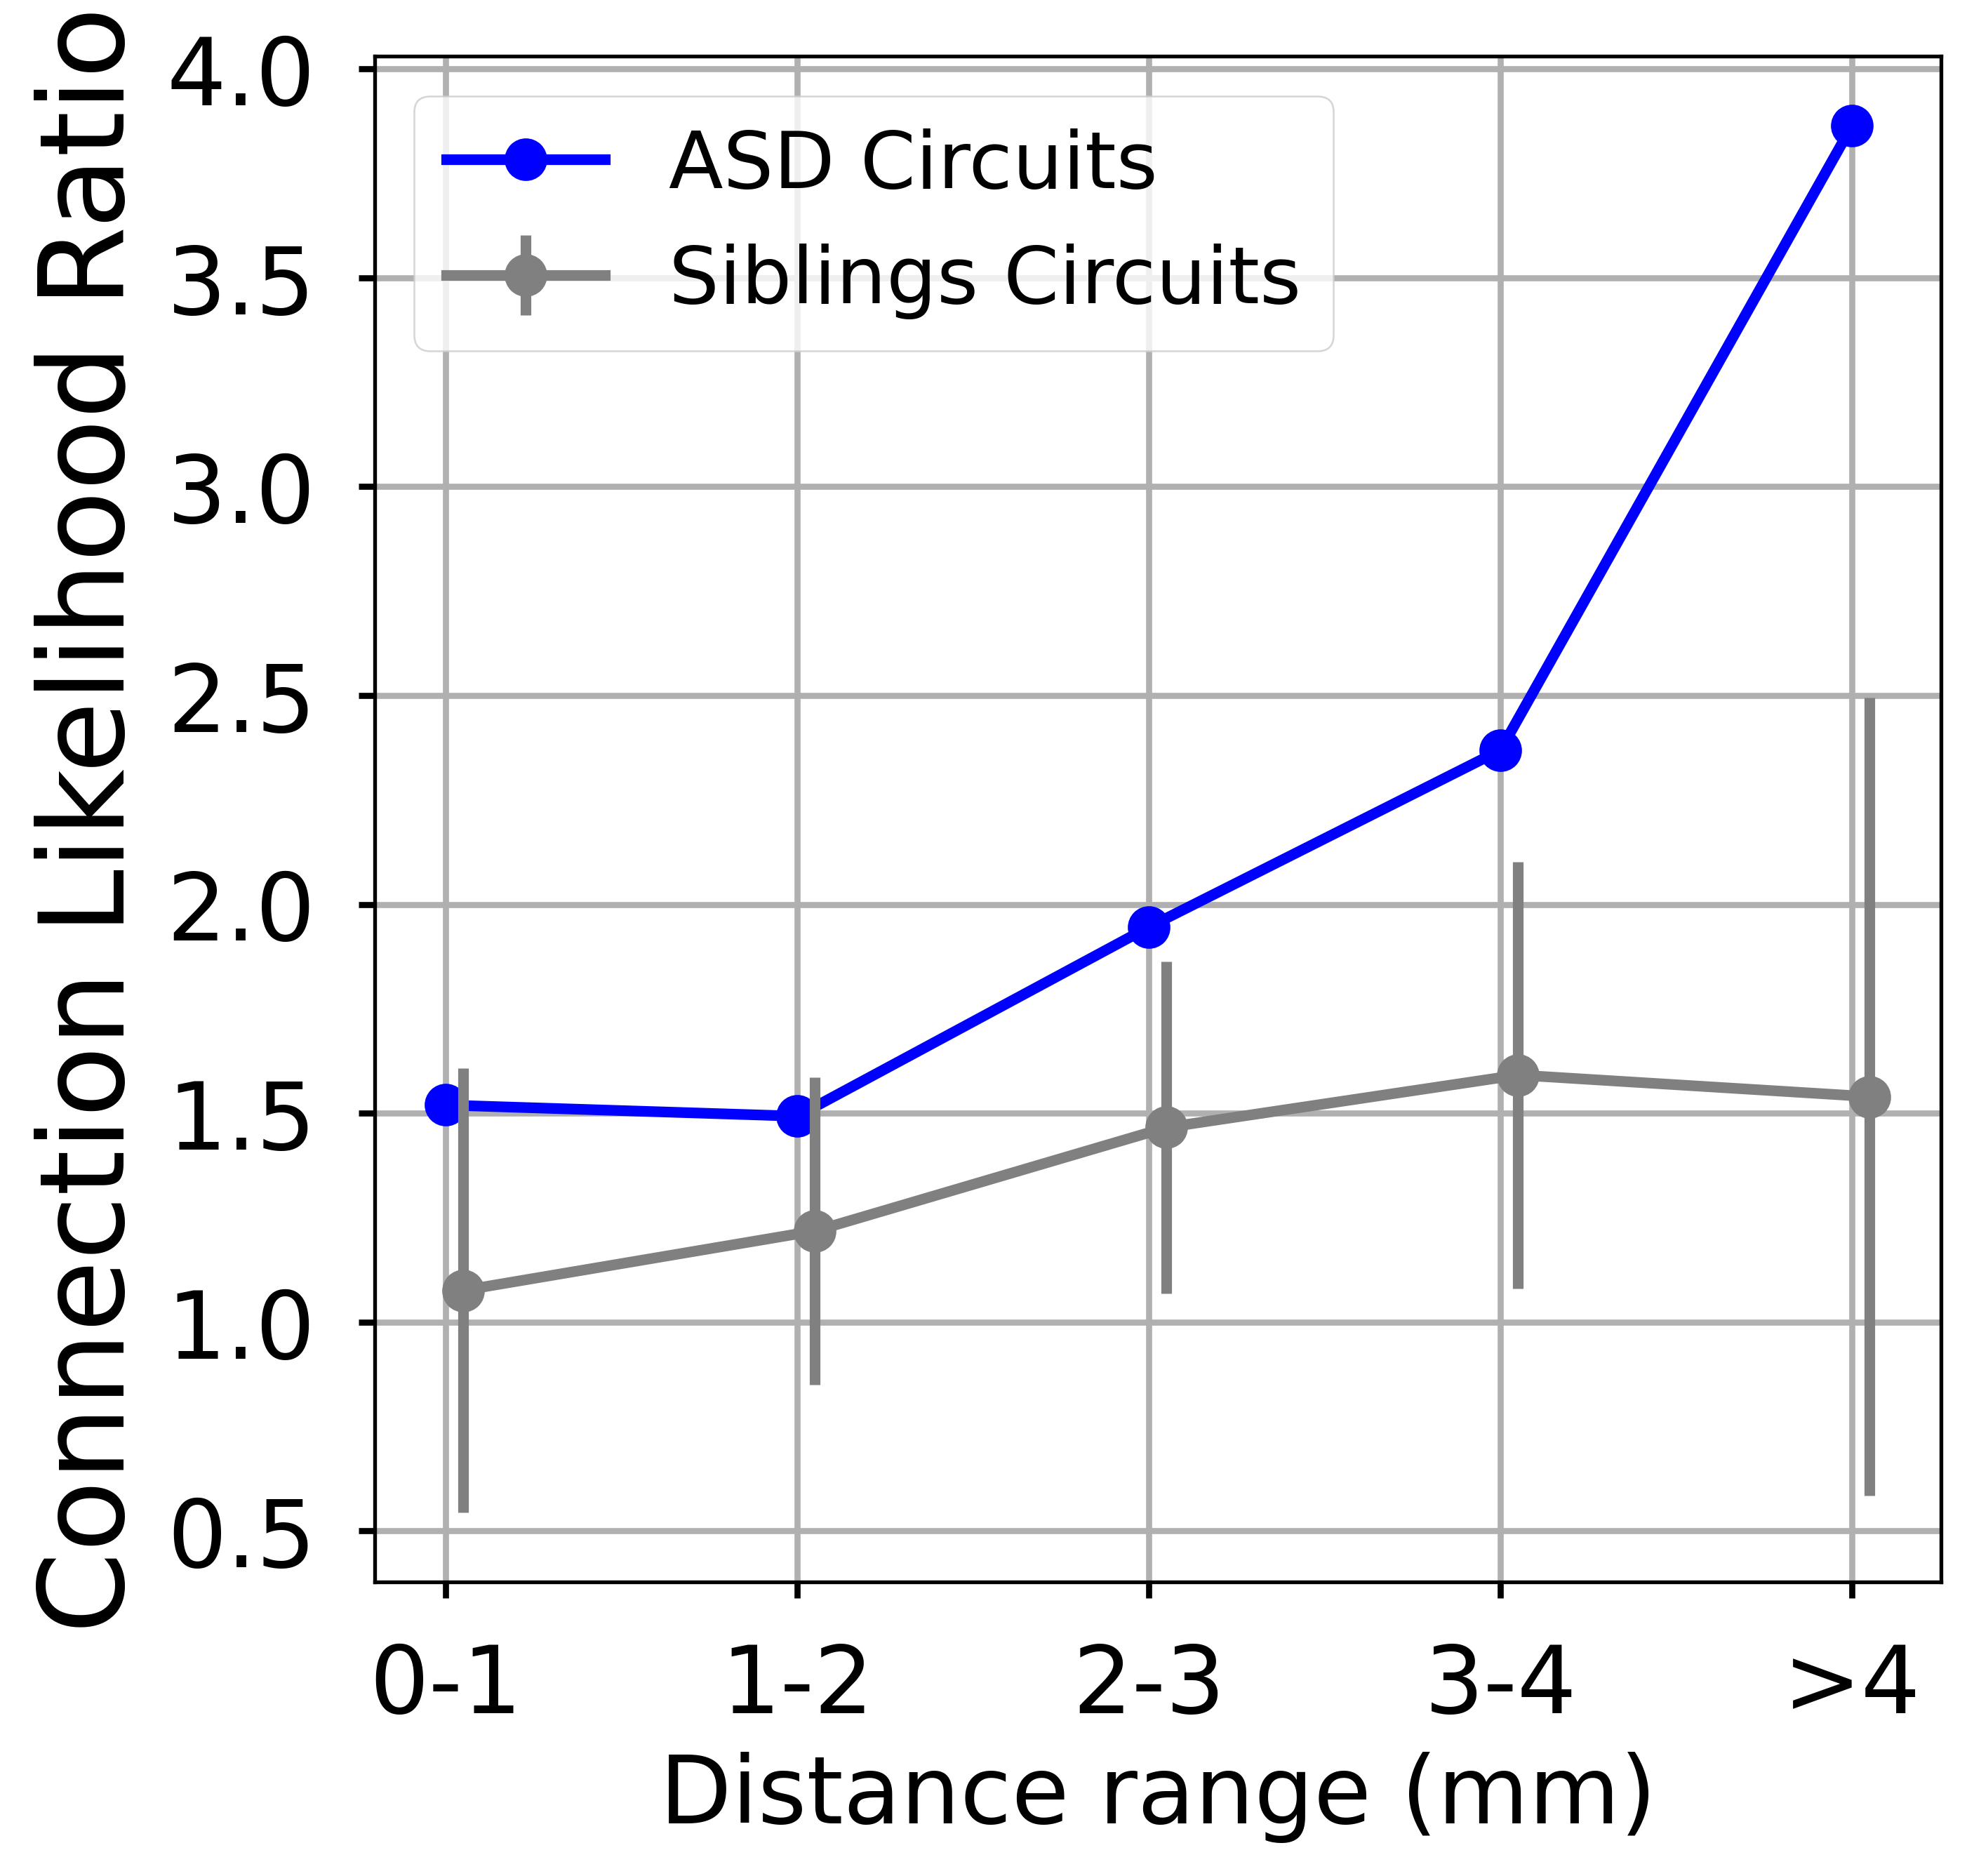

In [71]:
fig, ax = plt.subplots(dpi=480, figsize=(6,6))
norm = N_Connections_total/N_Pairs_total
ax.plot(np.arange(5), ASD_Connections/ASD_Pairs / norm , marker="o" , color="blue", label="ASD Circuits")
#ax.plot(np.arange(6) + 0.05, SIB_Connections/SIB_Pairs / norm, marker="o", color="orange", label="Sibling Circuits")
ax.errorbar(np.arange(5) + 0.05, 
                 subsib_conns_mean/subsib_pairs_mean / norm, 
                 yerr= np.nanstd(subsib_connections/subsib_Pairs/norm, axis=0),
                 marker="o", color="grey", label="Siblings Circuits")

ax.grid(True)
ax.legend(loc="upper left", fontsize=17)
ax.set_ylabel("Connection Likelihood Ratio", fontsize=25)
ax.set_xlabel(r"Distance range (mm)", fontsize=20)
#ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", "4-5", r">5"], fontsize=20)
ax.set_xticklabels(["", "0-1", "1-2", "2-3", "3-4", r">4"], fontsize=20)
ax.tick_params(axis='y', labelsize=20)
#plt.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%s x1000'))
#plt.tight_layout()
plt.show()